In [1]:
import numpy as np; np.random.seed(1218042)
import seaborn as sb; sb.set()
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm 

# Population Model of Competition between ride hailing platforms

Let $f_{R}(t, u)$ and $f_{D}(t, u)$ model the local densities of riders and drivers. Then their growths are determined by:

$$
\frac{\delta}{\delta t}f_{R}(t, u) = R_{R}(t, u)f_{R}(t, u) \qquad \frac{\delta}{\delta t}f_{D}(t, v) = R_{D}(t, v)f_{D}(t, v)
$$

where $R_{R}$ and $R_{D}$ model the net growth rates of rider and drivers respectively:

$$
R_{R}(t, u) := (\kappa_{R} - \mu_{R}\frac{f_{R}(t, u)}{f_{D}(t, u)}) - \int_{V} \eta_{\theta_{P}}(|u-v|)f_{D}(t, v)dv \qquad R_{D}(t, v) := [\int_{U}\eta_{\theta_{P}}(|u-v|)f_{R}(t, u)du + \kappa_{D}c_{I}(t)] - \frac{\mu_{D}}{1+\mu_{A}c_{A}(t)}\frac{f_{D}(t, v)}{f_{R}(t, v)}
$$

The implementation is as follows:

#### For riders:

* $\kappa_{R}$ the natural growth rate of rider agents (**barabasi effect on growth**),
* $\mu_{R}$ the reduction in platform attractiveness due to competition for ressources among riders (**waiting time effect**),
* $\rho_{R}(t)$ the total density of riders that are currently seeking rides (**unmet demant**),
* $\eta_{\theta_{P}}$ the price surge in effect with $\theta_{P}$ being the surge coefficient,
* $f_{D}(t, v)$ the density of drivers for platform $v$,
* $u$ indicator of riders for platform $u$,
* $V$ the set of platforms that drivers can join.


#### For drivers:

* $\eta_{\theta_{P}}$ the price surge in effect with $\theta_{P}$ being the surge coefficient,
* $f_{R}(t, u)$ the density of riders for platform $u$,
* $\kappa_{D}$ the natural growth rate of driver agents (**barabasi effect on growth**),
* $c_{I}(t)$ the effect of incentives presented to drivers for them to join platform $v$ (*e.g. financial, advertisment, ...*),
* $\mu_{D}$ the reduction of platform attractiveness for drivers due to competition for ressources amongst drivers (**idle time**),
* $\mu_{A}$ the reduction of platform attractiveness for drivers due to driver attrition,
* $c_{A}(t)$ the effect of external mitigations on driver attrition (*e.g. good employee development programs*),
* $\rho_{D}(t)$ the total density of drivers that are currently seeking rides,
* $v$ indicator of drivers for platform $u$,
* $U$ the set of platforms that riders can join.

#### Both $\kappa_{R}$ and $\kappa_{D}$ will take their platforms' growth into account in a "Barabasi" way:

$$\kappa_{R}(u_{i}) = \frac{\frac{\delta}{\delta t}f_{R}(t, u_{i})}{\sum_{j\ne i}^{U}\frac{\delta}{\delta t}f_{R}(t, u_{j})} \qquad \kappa_{D}(v_{i}) = \frac{\frac{\delta}{\delta t}f_{D}(t, v_{i})}{\sum_{j\ne i}^{V}\frac{\delta}{\delta t}f_{D}(t, v_{j})}$$

## Modelling the growth

To recreate the model, $f_{R,I}$ will be an array of its values where each index reprents its value at time $t$.

At every time step ($\Delta t = 0.1$):

$$f_{R}(t_{k+1}, u_{i}) = f_{R}(t_{k}, u_{i}) + \Delta t [R^{+}_{R}(t_{k}, u_{i})f_{R}(t_{k}, u_{i}) - R^{-}_{R}(t_{k}, u_{i})f_{R}(t_{k+1}, u_{i})] \qquad f_{D}(t_{k+1}, v_{i}) = f_{D}(t_{k}, v_{i}) + \Delta t [R^{+}_{D}(t_{k}, v_{i})f_{D}(t_{k}, v_{i}) - R^{-}_{D}(t_{k}, v_{i})f_{D}(t_{k+1}, v_{i})]$$

or in explicit terms:

$$f_{R}(t_{k+1}, u_{i}) = f_{R}(t_{k}, u_{i}) \frac{1+\Delta t R^{+}_{R}(t_{k}, u_{i})}{1+\Delta t R^{-}_{R}(t_{k}, u_{i})} \qquad f_{D}(t_{k+1}, v_{i}) = f_{D}(t_{k}, v_{i}) \frac{1+\Delta t R^{+}_{D}(t_{k}, v_{i})}{1+\Delta t R^{-}_{D}(t_{k}, v_{i})}$$

Each $u$ and $v$ is one of $N$ different platforms. We will run this simulation for various values of $N$.

In [22]:

class StockMarket():

    def __init__(self):
        # To store platform -> growths mapping
        self.platforms = {}

    def register(self, platform):
        """ Registers a platform to the market """
        self.platforms[platform] = {
            "rider": [],
            "driver": []
        }

    def submit_growth(self, growths, platforms, rider=True):
        """ Registers the growths of each hub to the platform """
        category = "rider" if rider else "driver"
        # Register the growth of each hub under its respective platform
        for growth, platform in zip(growths, platforms):
            # Get the hubs' platform
            self.platforms[platform][category].append(growth)

    def request_market_share(self, request, total=False):
        """ Returns a barabasi like market share of most recent growth """
        total_r_growths = 0
        total_d_growths = 0
        for platform, growths in self.platforms.items():
            # Fetch and accumulate the growths
            growths = growths["rider"][-1], growths["driver"][-1]
            total_r_growths += growths[0]
            total_d_growths += growths[1]
            # If the hub is part of the platform set this as the numerator
            if platform == request:
                r_growth, d_growth = growths
        # Return the ratios
        rider_ms = r_growth/total_r_growths if total_r_growths else 0
        driver_ms = d_growth/total_d_growths if total_d_growths else 0
        if not total:
            return rider_ms, driver_ms
        else:
            return (r_growth+d_growth)/(total_r_growths+total_d_growths) if total_r_growths+total_d_growths else 0


class PlatformSimulator():

    def __init__(self, stock_market, N=1, t=21, delta_T=0.1,
                        mu_R=0.5, mu_D=0.5, mu_A=1,
                        c_I=lambda t: 1, c_A=lambda t: 0,
                        f_R=lambda u: np.random.uniform(),
                        f_D=lambda v: np.random.uniform(),
                        theta_P=1000, debug=False):

        # Set the platform simulation parameters
        self.N = N
        self.platforms = np.arange(self.N)
        self.t = t
        self.delta_T = delta_T
        self.mu_R = mu_R
        self.mu_D = mu_D
        self.mu_A = mu_A
        self.c_I = c_I
        self.c_A = c_A
        self.f_R = f_R
        self.f_D = f_D
        self.theta_P = theta_P
        self.debug = debug
        
        # General densities of agents (using rectangle integration)
        self.rho_R = lambda f_R,u: f_R[u]#sum(f_R * 1/len(f_R))
        self.rho_D = lambda f_D,v: f_D[v]#sum(f_D * 1/len(f_D))

        # The price surge - to be set to 0 to start with
        self.eta_theta_P = lambda u,v: 0
        #self.eta_theta_P = lambda u,v: np.exp(-theta_P*np.square(np.abs(u-v)))

        # Setup the growth tracker and register the platforms
        self.stock_market = stock_market
        for platform in self.platforms:
            self.stock_market.register(platform)

        # Generate the initial values
        initial_r_growth = [self.f_R(u) for u in self.platforms]
        initial_d_growth = [self.f_D(v) for v in self.platforms]
        # Register these first growths
        self.stock_market.submit_growth(initial_r_growth, self.platforms)
        self.stock_market.submit_growth(initial_d_growth, self.platforms, rider=False)
        # Keep them in memory
        self.riders = np.array([initial_r_growth])
        self.drivers = np.array([initial_d_growth])

    def kappa_R(self, platform):
        """ Represents the growth of rider population """
        return self.stock_market.request_market_share(platform)[1]

    def kappa_D(self, platform):
        """ Represents the growth of driver population """
        return self.stock_market.request_market_share(platform)[0]

    def R_R(self, _f_R, u, _f_D):
        """ Generates the growth of the rider population """
        competition = self.mu_R*(self.rho_R(_f_R, u)/self.rho_D(_f_D, u))
        ride_cost = sum([self.eta_theta_P(u, v) * fv * 1/self.N for (fv, v) in zip(_f_D, self.platforms)])
        return self.kappa_R(u) - competition - ride_cost
    
    def R_D(self, _f_D, v, _f_R, t):
        """ Generates the growth of the driver population """
        ride_gain = sum([self.eta_theta_P(u, v) * fu * 1/self.N for (fu, u) in zip(_f_R, self.platforms)])
        attrition = self.mu_D/(1 + self.mu_A*self.c_A(t))*(self.rho_D(_f_D, v)/self.rho_R(_f_R, v))
        
        return ride_gain + self.kappa_D(v)*self.c_I(t) - attrition

    def split_positive_negative(self, values):
        """ Splits the input list into a list of its positives and negatives """
        positive, negative = [], []
        for v in values:
            p, n = (0, 0) if v == 0 else ((1, 0) if v > 0 else (0, 1))
            positive.append(v if p else 0)
            negative.append(v if n else 0)
        return np.array(positive), -np.array(negative)

    def simulate_growth(self, pbar=True):
        
        # Apply the growth equation for each time step
        for i in (tqdm(range(1, int(self.t/self.delta_T))) if pbar else range(1, int(self.t/self.delta_T))):
            
            # Get f_*[t]
            _f_R = self.riders[-1]
            _f_D = self.drivers[-1]
            
            if self.debug:
                # Compute the barabasi effect
                k_R = np.array([self.kappa_R(u) for u in self.platforms])
                k_D = np.array([self.kappa_D(v) for v in self.platforms])
                print(np.mean(k_R))
                print(np.mean(k_D), end="\n\n")

            # Compute the increments
            _R_C = [self.R_R(_f_R, u, _f_D) for u in self.platforms]
            _R_I = [self.R_D(_f_D, v, _f_R, i*self.delta_T) for v in self.platforms]
            
            # Get the positive and negative parts of _R_*
            p_R_R, n_R_R = self.split_positive_negative(_R_C)
            p_R_D, n_R_D = self.split_positive_negative(_R_I)
            
            # Compute the growths
            delta_R = (1 + self.delta_T*p_R_R) / (1 + self.delta_T*n_R_R)
            delta_D = (1 + self.delta_T*p_R_D) / (1 + self.delta_T*n_R_D)

            # Register the growths to the stock market
            self.stock_market.submit_growth(delta_R, self.platforms)
            self.stock_market.submit_growth(delta_D, self.platforms, rider=False)
            
            if self.debug:
                print(f"Time: {i} | k: {k_R} | delta: {delta_R} | _f_R: {_f_R}", end="\n\n")
            
            # Compute and aggregate f_*[t+1]
            self.riders = np.concatenate((self.riders, [_f_R * delta_R]))
            self.drivers = np.concatenate((self.drivers, [_f_D * delta_D]))
            
    def get_market_shares(self):
        return np.array([
            (self.drivers[:,n] + self.riders[:,n]) / (self.drivers + self.riders).sum(axis=1)
            for n in range(self.N)
        ])

    def plot_growth_surface(self, t=21):
        
        # Create a mesh-grid for printing
        initial_values, time = np.meshgrid(self.platforms, np.linspace(0, t, num=len(self.riders)))
        fig = plt.figure(figsize=(24, 8))

        #===============
        #  Cancer growth
        #===============
        # set up the axes for the first plot
        ax = fig.add_subplot(1, 2, 1, projection='3d')

        # Plot the surface
        ax.plot_surface(time, initial_values, self.riders)

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_ylabel('u', size=12)
        ax.set_zlabel('f_R(t, u)', size=12)
        plt.tight_layout()
        plt.title(f'Growth of rider agents', size=15)

        #===============
        # Immune growth
        #===============
        # set up the axes for the second plot
        ax = fig.add_subplot(1, 2, 2, projection='3d')

        # Plot the surface
        ax.plot_surface(time, initial_values, self.drivers)

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_ylabel('v', size=12)
        ax.set_zlabel('f_D(t, v)', size=12)
        plt.tight_layout()
        plt.title(f'Growth of driver agents', size=15)

        # Show entire figure
        plt.show()

    def plot_growth_cmap(self, t=21, log=False):

        fig = plt.figure(figsize=(12, 8))
        time = np.linspace(0, t, num=len(self.riders))
        # Setup the tick marks (for time and initial values)
        marks = [0, 200, 400, 600, 800, 1000, 1200]
        yticks = [int(t) if i in marks else '' for i,t in enumerate(time)][::-1]

        #===============
        #  Cancer growth
        #===============
        # set up the axes for the first plot
        ax = fig.add_subplot(1, 2, 1)

        # Plot the heatmap
        rider_plot = self.riders[::-1]
        if log:
            # Apply log to values to help visualize
            rider_plot = np.log(rider_plot)
        ax = sb.heatmap(rider_plot, robust=True, yticklabels=yticks, cmap='hot')

        # Set labels and title
        ax.set_xlabel('u', size=12)
        ax.set_ylabel('t', size=12)
        plt.tight_layout()
        plt.title(f'f_R(t, u){" (log)" if log else ""}', size=15)

        #===============
        # Immune growth
        #===============
        # set up the axes for the second plot
        ax = fig.add_subplot(1, 2, 2)

        # Plot the heatmap
        driver_plot = self.drivers[::-1]
        if log:
            # Apply log to values to help visualize
            driver_plot = np.log(driver_plot)
        ax = sb.heatmap(driver_plot, robust=True, yticklabels=yticks, cmap='hot')

        # Set labels and title
        ax.set_xlabel('v', size=12)
        ax.set_ylabel('t', size=12)
        plt.tight_layout()
        plt.title(f'f_D(t, v){" (log)" if log else ""}', size=15)

        # Show entire figure
        plt.show()

    def plot_densities(self, t=21, log=False):
    
        time = np.linspace(0, t, num=len(self.riders))

        # Plot the population growths
        plt.plot(time, self.riders.sum(axis=1)/self.N, color='black', label="Rider agents")
        plt.plot(time, self.drivers.sum(axis=1)/self.N, color='black', linestyle='--', label="Driver agents")

        # Set labels and title
        plt.xlabel('t', size=12)
        plt.xticks(list(range(0, t, 20)) if t==121 else time)
        if log:
            plt.yscale('log')
            plt.ylabel('log scaled values')
        plt.legend()
        plt.tight_layout()
        plt.title(f'ρ_R(t) and ρ_D(t)', size=15)
        plt.show()
        
    def plot_market_share(self, t=21):
        
        # Compute the market share and define the colors/timestamps
        market_share = np.array([
            (self.drivers[:,n] + self.riders[:,n]) / (self.drivers + self.riders).sum(axis=1)
            for n in range(self.N)
        ])
        time = np.linspace(0, t, num=len(self.riders))
        colors = plt.cm.RdYlGn(np.linspace(0, 1, self.N))
        
        # Plot each platforms market share evolution
        for c,p in zip(colors, self.platforms):
            plt.plot(time, market_share[p], color=c, label=f"Platform {p}")
        
        # Set labels and plot
        plt.xlabel("t", size=12)
        plt.ylabel("Market Share", size=12)
        plt.ylim(0, 1)
        plt.title("Evolution of market share throughout simulation", size=15)
        plt.tight_layout()
        plt.show()
        
    def plot_population_growth(self, t=21, log=False):
        
        # Setup the plot
        fig = plt.figure(figsize=(12, 6))
        time = np.linspace(0, t, num=len(self.riders))
        colors = plt.cm.RdYlGn(np.linspace(0, 1, self.N))
        
        # Plot the population per platform
        ax = fig.add_subplot(1, 2, 1)
        for c, p in zip(colors, self.platforms):
            ax.plot(time, self.riders[:,p], color=c, label=f"Platform {p} Rider agents")
            ax.plot(time, self.drivers[:,p], color=c, linestyle='--', label=f"Platform {p} Driver agents")

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_xticks(list(range(0, t, 20)) if t==121 else list(range(0, t, 5)))
        plt.legend()
        plt.tight_layout()
        plt.title(f'f_R(t) and f_D(t)', size=15)

        # Plot the growths per platform
        ax = fig.add_subplot(1, 2, 2)
        for c, (p, growths) in zip(colors, self.stock_market.platforms.items()):
            ax.plot(time, growths["rider"], color=c, label=f"Platform {p} Rider agents")
            ax.plot(time, growths["driver"], color=c, linestyle='--', label=f"Platform {p} Driver agents")

        # Set labels and title
        ax.set_xlabel('t', size=12)
        ax.set_xticks(list(range(0, t, 20)) if t==121 else list(range(0, t, 5)))
        plt.legend()
        plt.tight_layout()
        plt.title(f'R_R(t) and R_D(t)', size=15)
        plt.show()
    
        

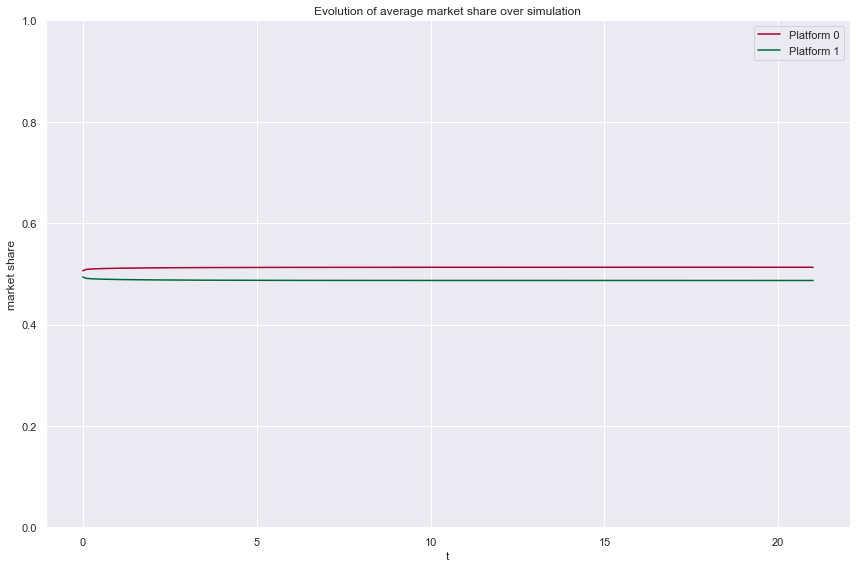

In [40]:
market_shares = []
for _ in tqdm(range(1000)):
    stock_market = StockMarket()

    sim = PlatformSimulator(stock_market, N=2, mu_D=0.1, mu_R=0.1,
                            f_R=lambda u: 1+np.random.uniform(),
                            f_D=lambda v: np.random.uniform())
    sim.simulate_growth(pbar=False)
    market_shares.append(sim.get_market_shares())
market_shares = np.mean(market_shares, axis=0)

plt.figure(figsize=(12,8))
time = np.linspace(0, sim.t, num=len(sim.riders))
colors = plt.cm.RdYlGn(np.linspace(0, 1, sim.N))
for c, p in zip(colors, sim.platforms):
    plt.plot(time, market_shares[p], color=c, label=f"Platform {p}")

plt.xlabel("t", size=12)
plt.ylabel("market share", size=12)
plt.ylim(0, 1)
plt.title("Evolution of average market share over simulation")
plt.legend()
plt.tight_layout()
plt.show()

### Running the default simulation with a single platform


With u_0 > v_0


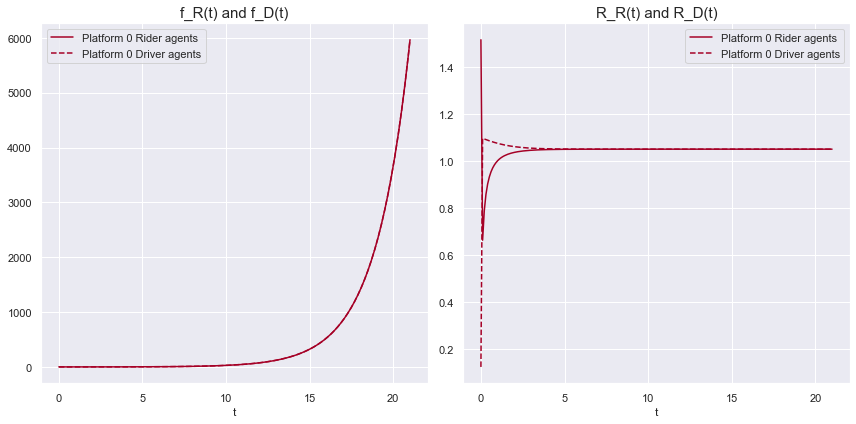



With u_0 < v_0


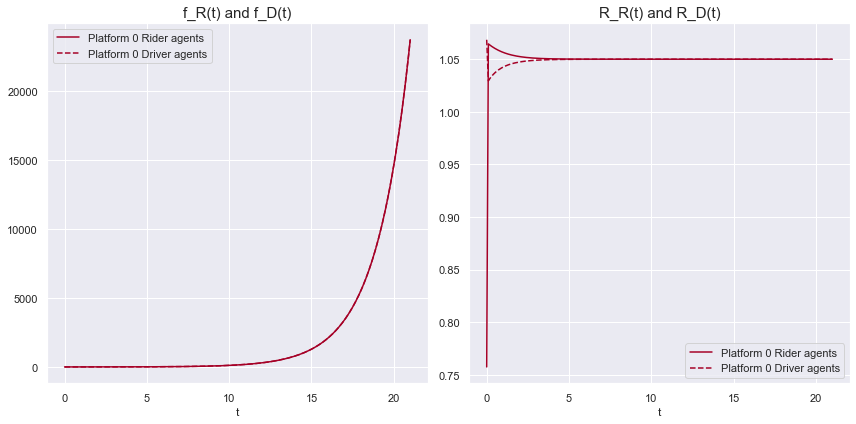

In [3]:
stock_market = StockMarket()

sim = PlatformSimulator(stock_market, N=1,
                        f_R=lambda u: 1+np.random.uniform(),
                        f_D=lambda v: np.random.uniform())
sim.simulate_growth()
print("With u_0 > v_0")
sim.plot_population_growth()

stock_market = StockMarket()
sim = PlatformSimulator(stock_market, N=1,
                        f_R=lambda u: np.random.uniform(),
                        f_D=lambda v: 1+np.random.uniform())
sim.simulate_growth()
print("\nWith u_0 < v_0")
sim.plot_population_growth()

### Running the default simulation with two platform


With u_0 > v_0


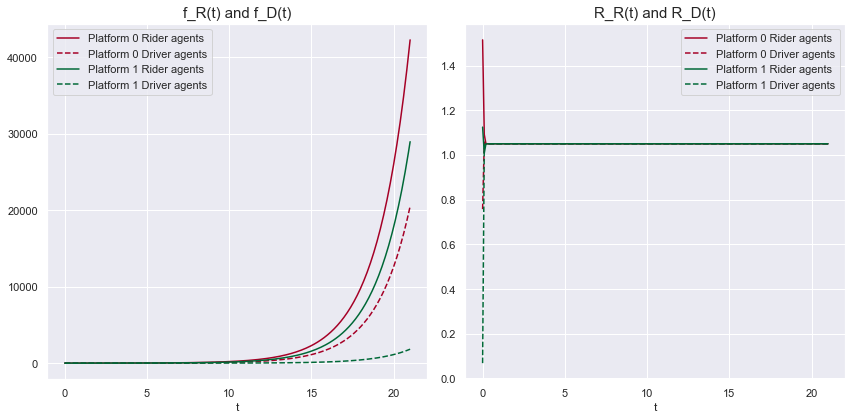


With u_0 < v_0


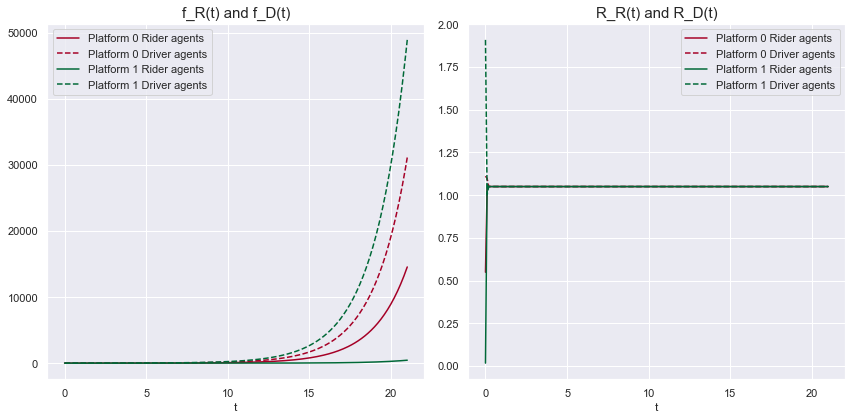

In [14]:
stock_market = StockMarket()

sim = PlatformSimulator(stock_market, N=2, mu_D=0, mu_R=0,
                        f_R=lambda u: 1+np.random.uniform(),
                        f_D=lambda v: np.random.uniform())
sim.simulate_growth()
print("\nWith u_0 > v_0")
sim.plot_population_growth()

stock_market = StockMarket()

sim = PlatformSimulator(stock_market, N=2, mu_D=0, mu_R=0,
                        f_R=lambda u: np.random.uniform(),
                        f_D=lambda v: 1+np.random.uniform())
sim.simulate_growth()
print("\nWith u_0 < v_0")
sim.plot_population_growth()

### Running the default simulation with three platform


With u_0 > v_0


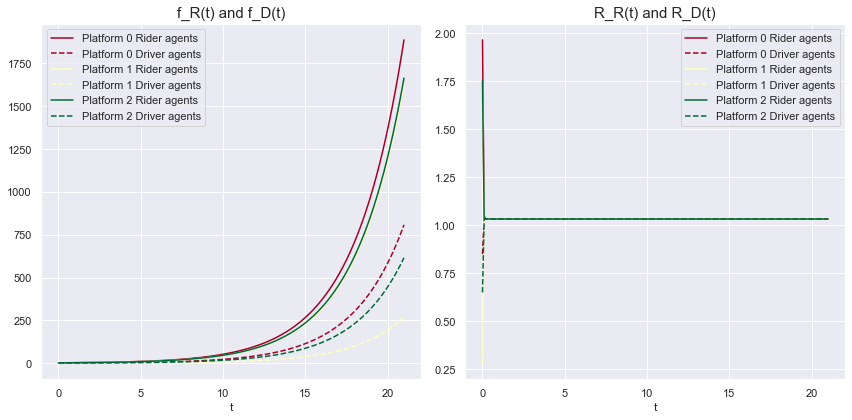


With u_0 < v_0


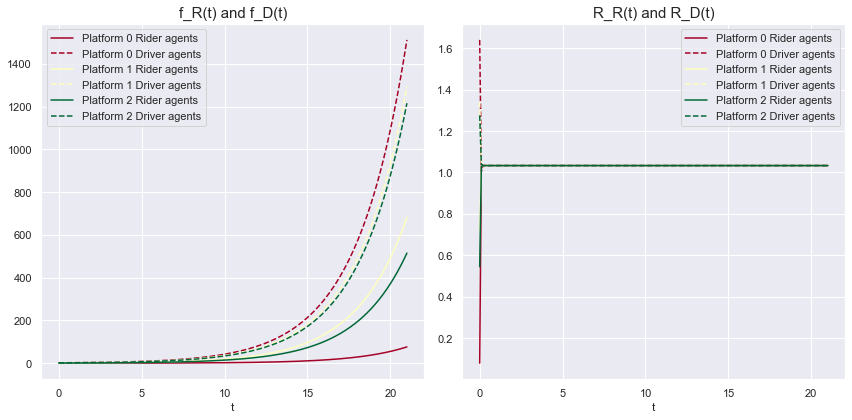

In [16]:
stock_market = StockMarket()

sim = PlatformSimulator(stock_market, N=3, mu_D=0, mu_R=0,
                        f_R=lambda u: 1+np.random.uniform(),
                        f_D=lambda v: np.random.uniform())
sim.simulate_growth()
print("\nWith u_0 > v_0")
sim.plot_population_growth()

stock_market = StockMarket()

sim = PlatformSimulator(stock_market, N=3, mu_D=0, mu_R=0,
                        f_R=lambda u: np.random.uniform(),
                        f_D=lambda v: 1+np.random.uniform())
sim.simulate_growth()
print("\nWith u_0 < v_0")
sim.plot_population_growth()

### Visualising the impact of $\mu_D$ and $\mu_R$ on the final number of agents for a single platform model


With u_0 > v_0


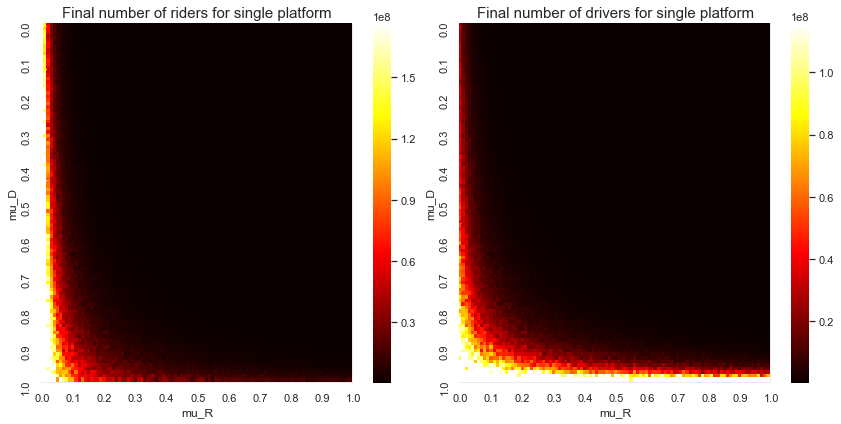


With u_0 < v_0


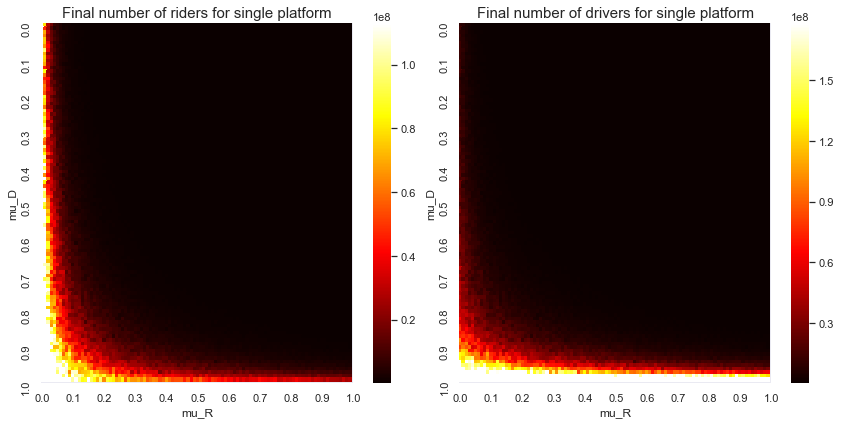

In [10]:
n = 100
mu = np.linspace(0, 1, num=n)
d_space = np.zeros((n, n))
r_space = np.zeros((n, n))
for d, mu_D_i in tqdm(enumerate(mu)):
    for r, mu_R_i in enumerate(mu):

        # Run a simulation with each possible pair of mu_D & mu_R
        r_acc, d_acc = [], []
        for _ in range(10):
            # Aggregate a mean value
            stock_market = StockMarket()
            sim = PlatformSimulator(stock_market, N=1, mu_R=mu_R_i, mu_D=mu_D_i,
                                    f_R=lambda u: 1+np.random.uniform(),
                                    f_D=lambda v: np.random.uniform())
            sim.simulate_growth(pbar=False)
            d_acc.append(sim.drivers[-1,0])
            r_acc.append(sim.riders[-1,0])
            
        d_space[d, r] = np.mean(d_acc)
        r_space[d, r] = np.mean(r_acc)
        
print("\nWith u_0 > v_0")

fig = plt.figure(figsize=(12, 6))
ticks = [str(i/100) if i%10==0 else '' for i in range(0, n+1)]
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
# Plot the riders
ax = sb.heatmap(r_space[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks)
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title(f'Final number of riders for single platform', size=15)

# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)
# Plot the drivers
ax = sb.heatmap(d_space[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks)
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title(f'Final number of drivers for single platform', size=15)

# Show entire figure
plt.show()


##################################################################################################

d_space = np.zeros((n, n))
r_space = np.zeros((n, n))
for d, mu_D_i in tqdm(enumerate(mu)):
    for r, mu_R_i in enumerate(mu):

        # Run a simulation with each possible pair of mu_D & mu_R
        r_acc, d_acc = [], []
        for _ in range(10):
            # Aggregate a mean value
            stock_market = StockMarket()
            sim = PlatformSimulator(stock_market, N=1, mu_R=mu_R_i, mu_D=mu_D_i,
                                    f_R=lambda u: np.random.uniform(),
                                    f_D=lambda v: 1+np.random.uniform())
            sim.simulate_growth(pbar=False)
            d_acc.append(sim.drivers[-1,0])
            r_acc.append(sim.riders[-1,0])
            
        d_space[d, r] = np.mean(d_acc)
        r_space[d, r] = np.mean(r_acc)
        
print("\nWith u_0 < v_0")

fig = plt.figure(figsize=(12, 6))
ticks = [str(i/100) if i%10==0 else '' for i in range(0, n+1)]
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1)
# Plot the riders
ax = sb.heatmap(r_space[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks)
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title(f'Final number of riders for single platform', size=15)

# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)
# Plot the drivers
ax = sb.heatmap(d_space[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks)
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title(f'Final number of drivers for single platform', size=15)

# Show entire figure
plt.show()

### Visualising the impact of $\mu_D$ and $\mu_R$ on the different number of agents for a dual platform model
_initially, there are more riders than drivers ($u_{0} > v_{0}$)_

In [44]:
n = 100
mu = np.linspace(0, 1, num=n)
# Setting up the values
delta_market_share = np.zeros((n, n))
delta_total = np.zeros((n, n))
delta_drivers = np.zeros((n, n))
delta_riders = np.zeros((n, n))
delta_inner_1 = np.zeros((n, n))
delta_inner_2 = np.zeros((n, n))
for d, mu_D_i in tqdm(enumerate(mu), total=n):
    for r, mu_R_i in enumerate(mu):

        # Run a simulation with each possible pair of mu_D & mu_R
        avg_d_ms = []
        avg_d_total = []
        avg_d_drivers = []
        avg_d_riders = []
        avg_d_inner_1 = []
        avg_d_inner_2 = []
        for _ in range(100):
            # Aggregate a mean value
            stock_market = StockMarket()
            sim = PlatformSimulator(stock_market, N=2, mu_R=mu_R_i, mu_D=mu_D_i,
                                    f_R=lambda u: 1+np.random.uniform(),
                                    f_D=lambda v: np.random.uniform())
            sim.simulate_growth(pbar=False)
            # Get the total number of riders and drivers
            drivers_1 = sim.drivers[-1,0]
            drivers_2 = sim.drivers[-1,1]
            riders_1 = sim.riders[-1,0]
            riders_2 = sim.riders[-1,1]
            # Get the different market shares
            ms_1 = (drivers_2+riders_2) / (drivers_1+drivers_2+riders_1+riders_2)
            ms_2 = (drivers_1+riders_1) / (drivers_1+drivers_2+riders_1+riders_2)
            # Compute the total differences
            avg_d_ms.append(np.abs(ms_1 - ms_2))
            avg_d_total.append(np.abs((drivers_1+riders_1) - (drivers_2+riders_2)))
            avg_d_drivers.append(np.abs(drivers_1 - drivers_2))
            avg_d_riders.append(np.abs(riders_1 - riders_2))
            avg_d_inner_1.append(riders_1 - drivers_1)
            avg_d_inner_2.append(riders_2 - drivers_2)
        
        # Get the mean values and store
        delta_market_share[d, r] = np.mean(avg_d_ms)
        delta_total[d, r] = np.mean(avg_d_total)
        delta_drivers[d, r] = np.mean(avg_d_drivers)
        delta_riders[d, r] = np.mean(avg_d_riders)
        delta_inner_1[d, r] = np.mean(avg_d_inner_1)
        delta_inner_2[d, r] = np.mean(avg_d_inner_2)

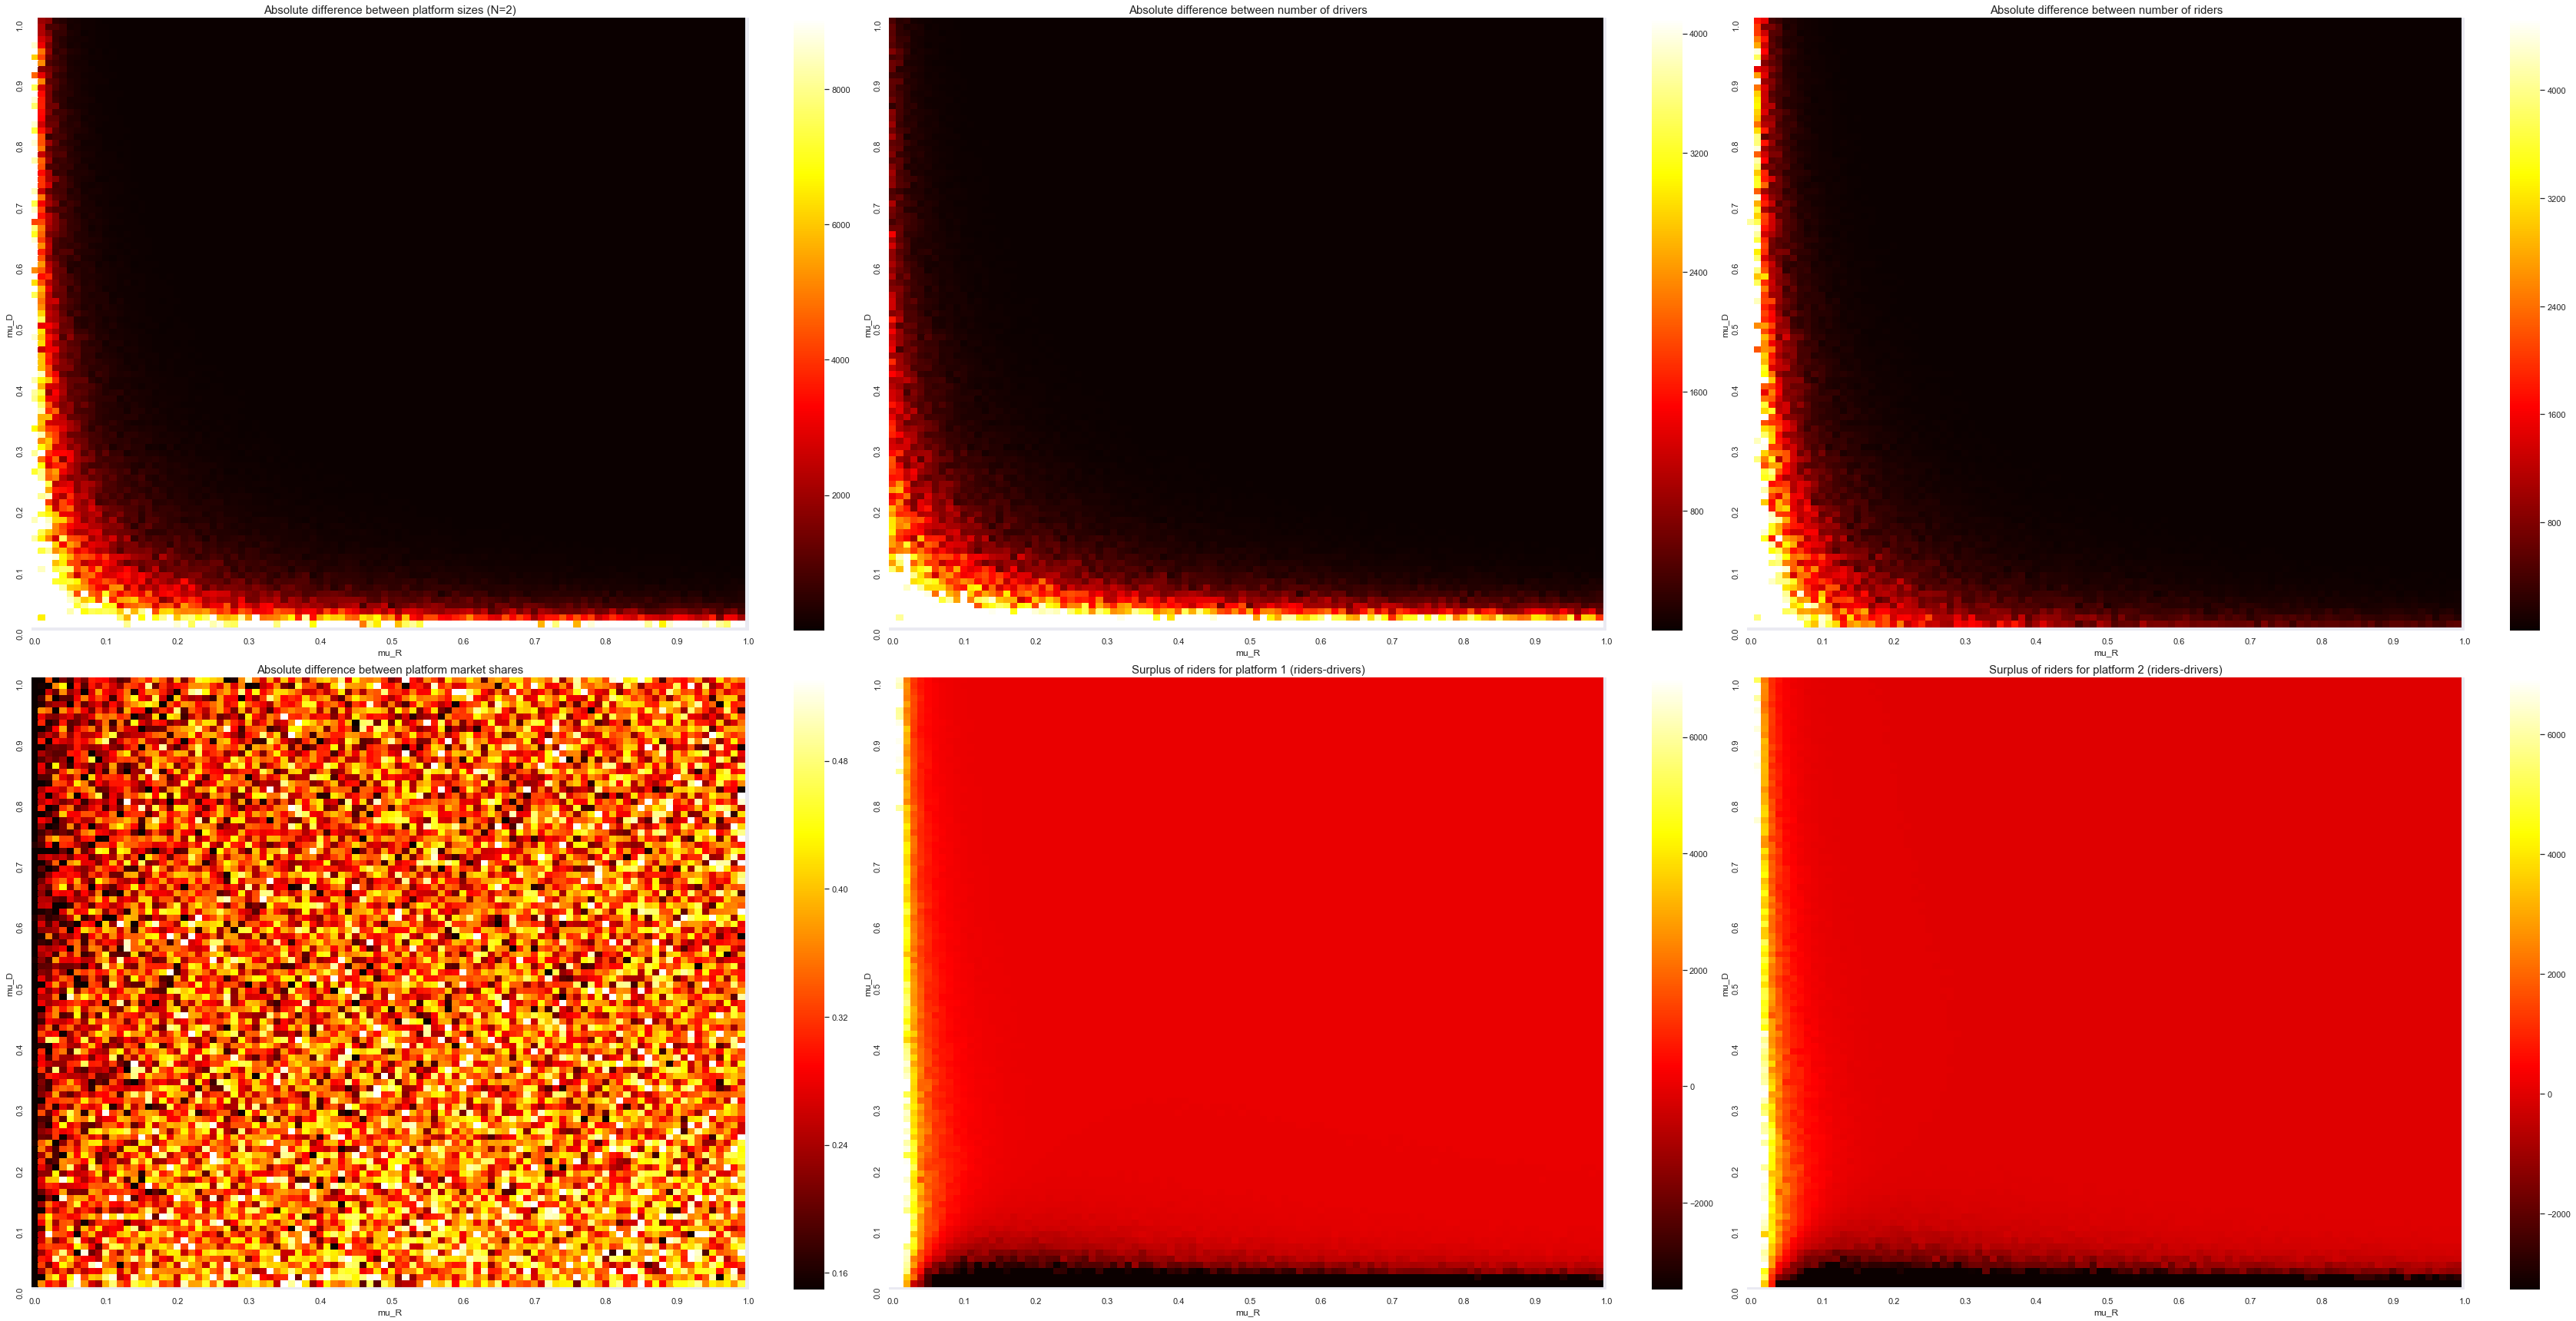

In [4]:
# Setting up the figure size
fig = plt.figure(figsize=(48, 24))
# Writing the ticks for the mu's
ticks = [str(i/100) if i%10==0 else '' for i in range(0, n+1)]

ax = fig.add_subplot(2, 3, 1)
# Plot the delta totals
ax = sb.heatmap(delta_total[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between platform sizes (N=2)', size=15)

ax = fig.add_subplot(2, 3, 2)
# Plot the delta drivers
ax = sb.heatmap(delta_drivers[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between number of drivers', size=15)

ax = fig.add_subplot(2, 3, 3)
# Plot the delta riders
ax = sb.heatmap(delta_riders[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between number of riders', size=15)

ax = fig.add_subplot(2, 3, 4)
# Plot the difference in agents for platform 1
ax = sb.heatmap(delta_market_share[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between platform market shares', size=15)

ax = fig.add_subplot(2, 3, 5)
# Plot the difference in agents for platform 1
ax = sb.heatmap(delta_inner_1[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Surplus of riders for platform 1 (riders-drivers)', size=15)

ax = fig.add_subplot(2, 3, 6)
# Plot the difference in agents for platform 2
ax = sb.heatmap(delta_inner_2[::-1], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Surplus of riders for platform 2 (riders-drivers)', size=15)

# Show entire figure
plt.show()

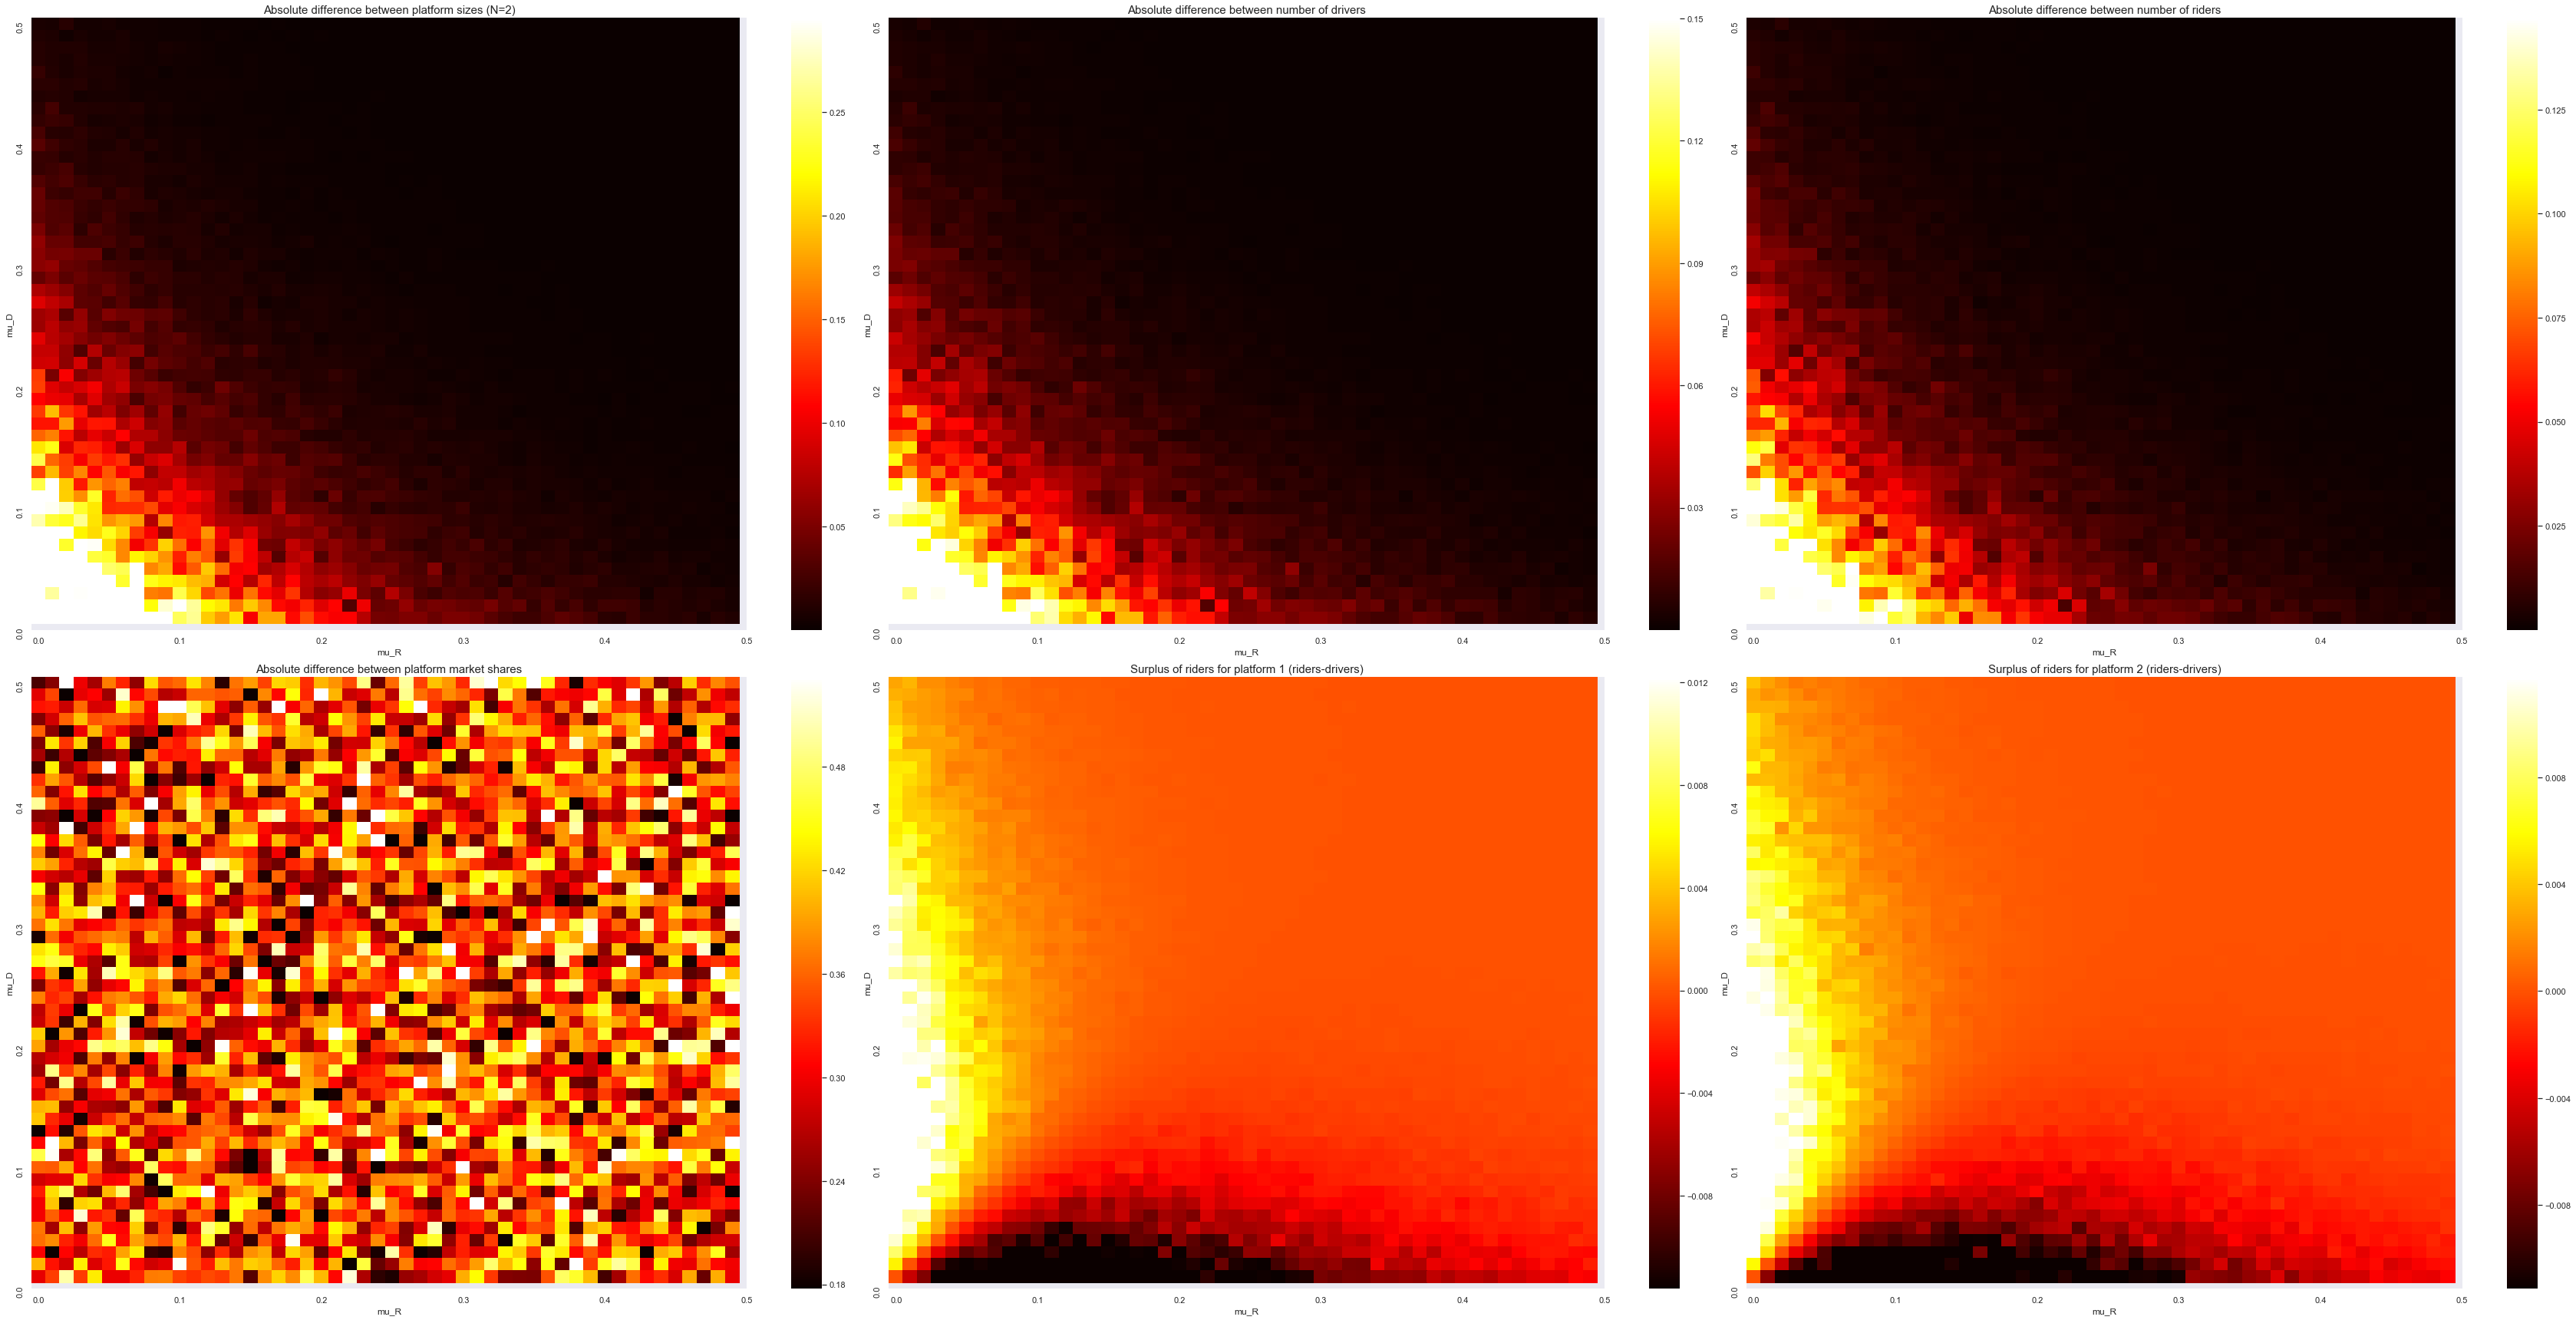

In [5]:
n = 50
# Setting up the figure size
fig = plt.figure(figsize=(48, 24))
# Writing the ticks for the mu's
ticks = [str(i/100) if i%10==0 else '' for i in range(0, n+1)]

ax = fig.add_subplot(2, 3, 1)
# Plot the delta totals
ax = sb.heatmap(delta_total[::-1][:n,-n:], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between platform sizes (N=2)', size=15)

ax = fig.add_subplot(2, 3, 2)
# Plot the delta drivers
ax = sb.heatmap(delta_drivers[::-1][:n,-n:], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between number of drivers', size=15)

ax = fig.add_subplot(2, 3, 3)
# Plot the delta riders
ax = sb.heatmap(delta_riders[::-1][:n,-n:], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between number of riders', size=15)

ax = fig.add_subplot(2, 3, 4)
# Plot the difference in agents for platform 1
ax = sb.heatmap(delta_market_share[::-1][:n,-n:], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Absolute difference between platform market shares', size=15)

ax = fig.add_subplot(2, 3, 5)
# Plot the difference in agents for platform 1
ax = sb.heatmap(delta_inner_1[::-1][:n,-n:], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Surplus of riders for platform 1 (riders-drivers)', size=15)

ax = fig.add_subplot(2, 3, 6)
# Plot the difference in agents for platform 2
ax = sb.heatmap(delta_inner_2[::-1][:n,-n:], robust=True, cmap='hot', xticklabels=ticks, yticklabels=ticks[::-1])
# Set labels and title
ax.set_xlabel('mu_R', size=12)
ax.set_ylabel('mu_D', size=12)
plt.tight_layout()
plt.title('Surplus of riders for platform 2 (riders-drivers)', size=15)

# Show entire figure
plt.show()